# Importación de bibliotecas

In [121]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np
import random

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Selección de atributos
# ==============================================================================
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import VarianceThreshold

# Preprocesamiento
# ==============================================================================
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import PowerTransformer


# Modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
## KNN
from sklearn.neighbors import KNeighborsRegressor
## Árboles
from sklearn.tree import DecisionTreeRegressor
## Lineales
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
## SVM
from sklearn.svm import SVR
## Random Forest
from sklearn.ensemble import RandomForestRegressor
## XGBoost
from xgboost import XGBRegressor, plot_importance

from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import PredefinedSplit

# Métricas
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Ajuste de hiperparámetros 
from optuna.integration import OptunaSearchCV
from optuna.distributions import IntDistribution, FloatDistribution, CategoricalDistribution
from optuna.visualization.matplotlib import plot_contour, plot_param_importances, plot_intermediate_values
from optuna.logging import set_verbosity, WARNING
set_verbosity(WARNING)

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')

# Medir tiempo
import time

# Semilla
random_seed = 36
np.random.seed(random_seed)
random.seed(random_seed)

# EDA

## Carga de los datos

In [122]:
disp_df = pd.read_csv("disp_st36ns1.txt.bz2", compression="bz2", index_col=0)

Hemos decidido añadir el día del año como un nuevo atributo al dataset. Consideramos que puede aportar información útil para hacer predicciones.

Suponemos que los datos comienzan el 01 de enero y continúan 12 años

In [123]:
daylist = []
for year in range(12):
    for day in range(365):
        daylist.append(day)
disp_df['date'] = daylist

Se transforman los índices de tipo texto a tipo entero

In [124]:
disp_df = disp_df.reset_index(drop=True)

## Análisis exploratorio de los datos

### Atributos del Dataset

In [125]:
print("El dataset tiene", disp_df.shape[0], "filas y", disp_df.shape[1], "atributos")

El dataset tiene 4380 filas y 77 atributos


El dataset tiene 75+1 variables independientes y 1 variable dependiente

Todas las variables son numéricas

In [126]:
print("Los tipos de atributos del dataset disp_df son:")
disp_df.info()

Los tipos de atributos del dataset disp_df son:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 77 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   apcp_sf1_1  4380 non-null   float64
 1   apcp_sf2_1  4380 non-null   float64
 2   apcp_sf3_1  4380 non-null   float64
 3   apcp_sf4_1  4380 non-null   float64
 4   apcp_sf5_1  4380 non-null   float64
 5   dlwrf_s1_1  4380 non-null   float64
 6   dlwrf_s2_1  4380 non-null   float64
 7   dlwrf_s3_1  4380 non-null   float64
 8   dlwrf_s4_1  4380 non-null   float64
 9   dlwrf_s5_1  4380 non-null   float64
 10  dswrf_s1_1  4380 non-null   float64
 11  dswrf_s2_1  4380 non-null   float64
 12  dswrf_s3_1  4380 non-null   float64
 13  dswrf_s4_1  4380 non-null   float64
 14  dswrf_s5_1  4380 non-null   float64
 15  pres_ms1_1  4380 non-null   float64
 16  pres_ms2_1  4380 non-null   float64
 17  pres_ms3_1  4380 non-null   float64
 18  pres_ms4_1  4380 non

No hay datos nulos en el dataset

In [127]:
print("Los nulos de cada atributo del dataset son:")
print(disp_df.isnull().sum())

Los nulos de cada atributo del dataset son:
apcp_sf1_1    0
apcp_sf2_1    0
apcp_sf3_1    0
apcp_sf4_1    0
apcp_sf5_1    0
             ..
uswrf_s3_1    0
uswrf_s4_1    0
uswrf_s5_1    0
salida        0
date          0
Length: 77, dtype: int64


Separamos entre variables dependientes e independientes

In [128]:
Y_df = disp_df['salida']
X_df = disp_df.drop(columns='salida')

### Gráficos

Distribución de frecuencia de la variable dependiente (salida)

Los datos no parecen seguir ninguna distribución conocida.

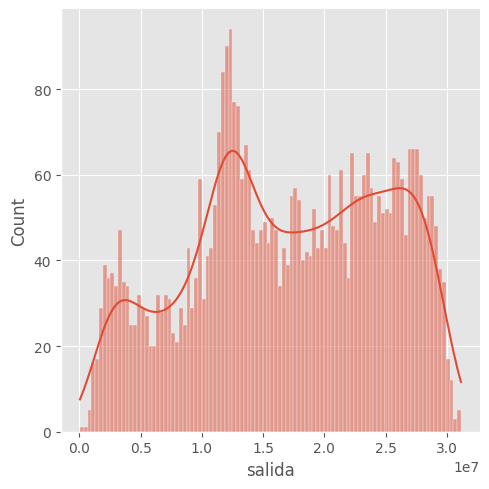

In [129]:
sns.displot(data=disp_df['salida'], bins=100, kde=True)

Correlación entre variables dependientes

La presión atmosférica parece ser la variable que más correlacionada está con el resto

<Axes: >

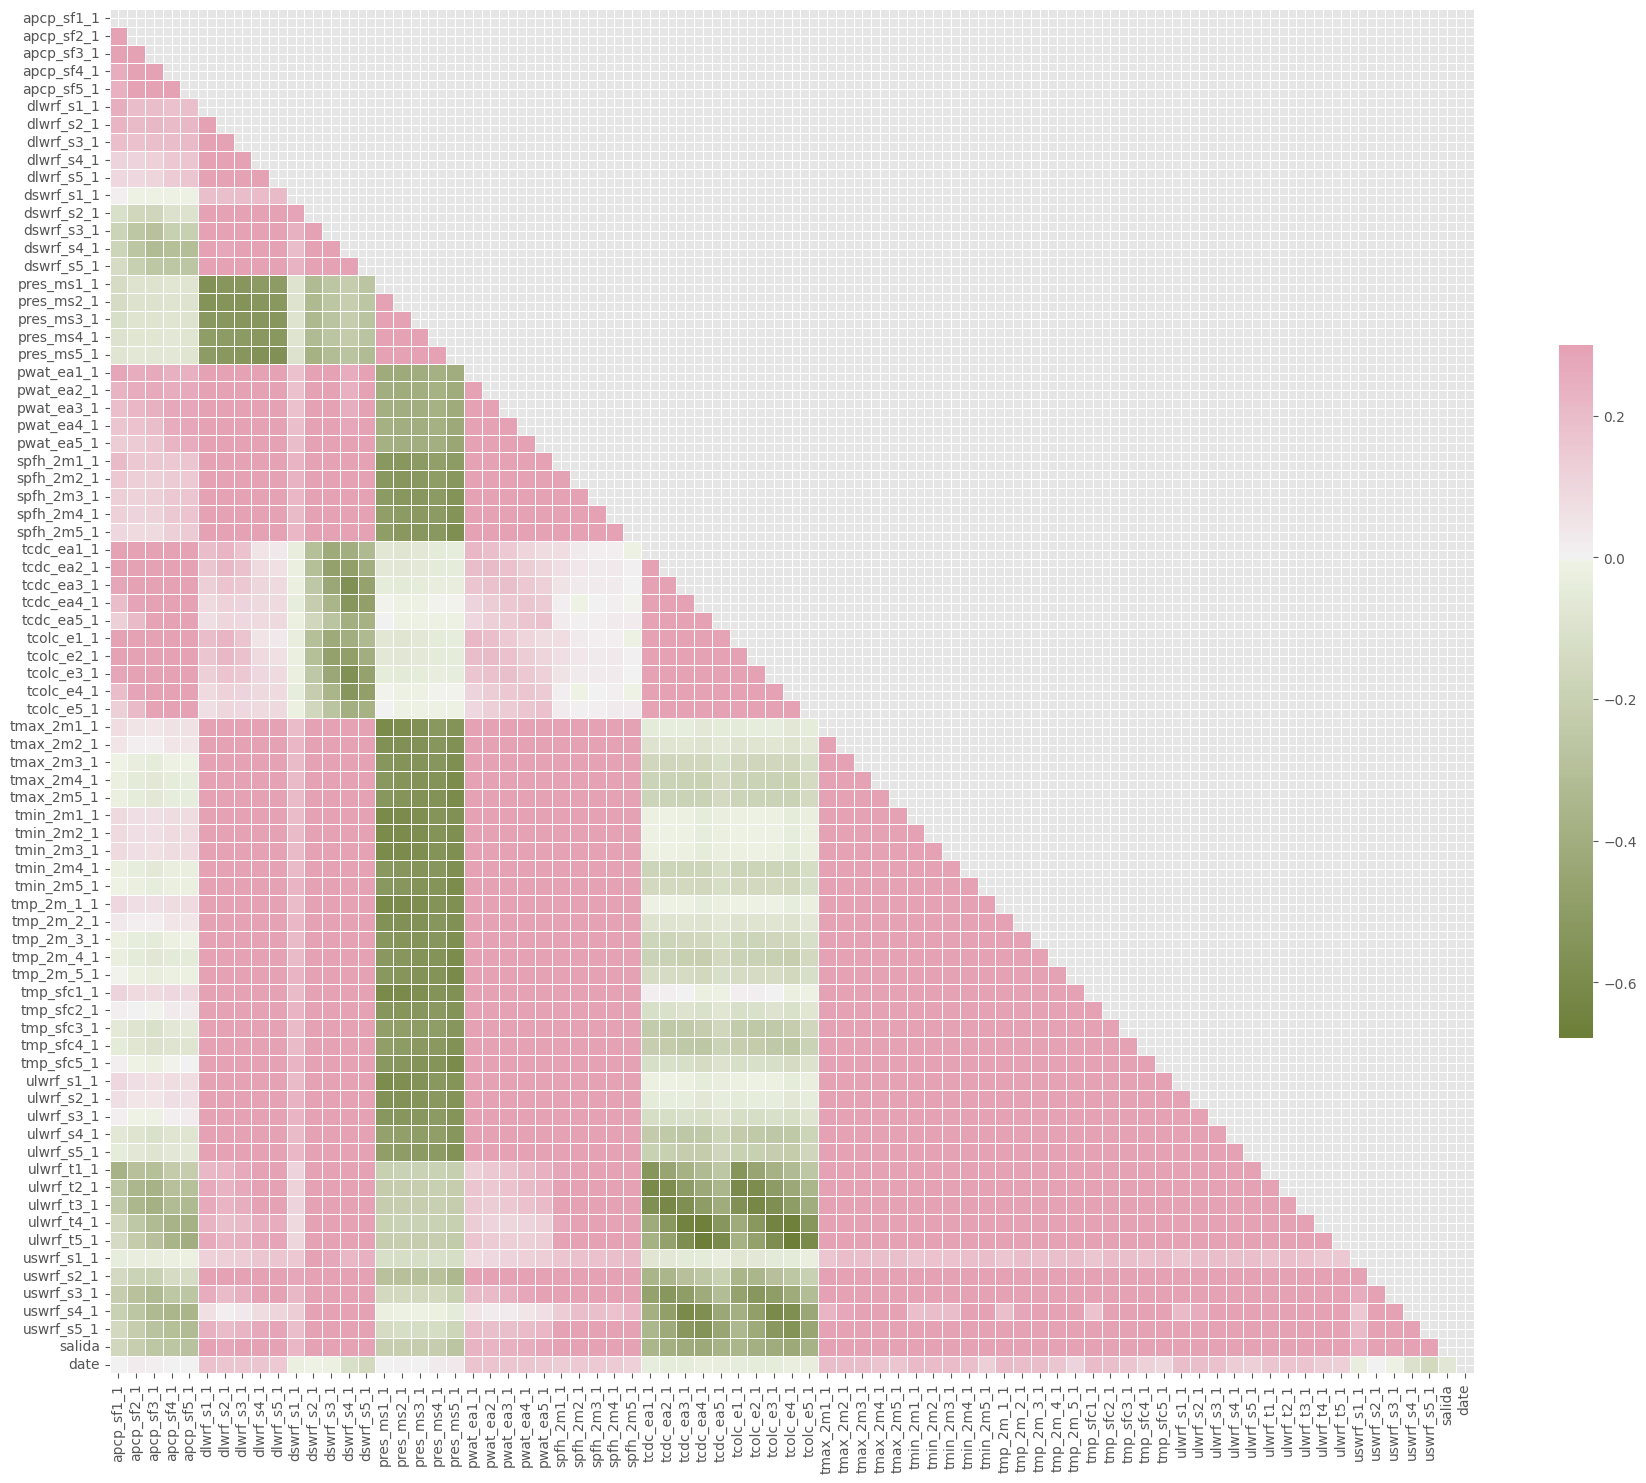

In [130]:
corr = disp_df.corr()

# Máscara para el triángulo superior
mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(22, 18))

cmap = sns.diverging_palette(100, 0, as_cmap=True, center='light')

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Distrbución de la producción acumulada según el día del año

Los puntos más oscuros indican mayor concentración de datos. En este caso el atributo salida se concentra mucho en el borde de la distribución.

El día del año es muy determinante para la producción acumulada.

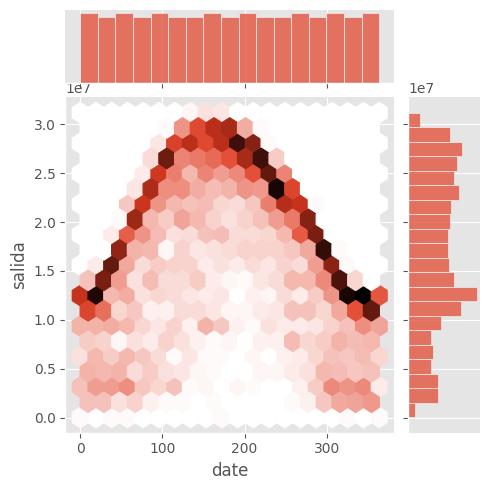

In [131]:
sns.jointplot(data=disp_df, x="date", y="salida", kind="hex", height=5, ratio=4)

Ahora veamos la ganancia de información de cada variable.

Ganancia de información en regresión (MutualInformation) por cada variable explicativa

Las variables que miden la radiación y la fecha son importantes para establecer la cantidad acumulada de energía

<Axes: >

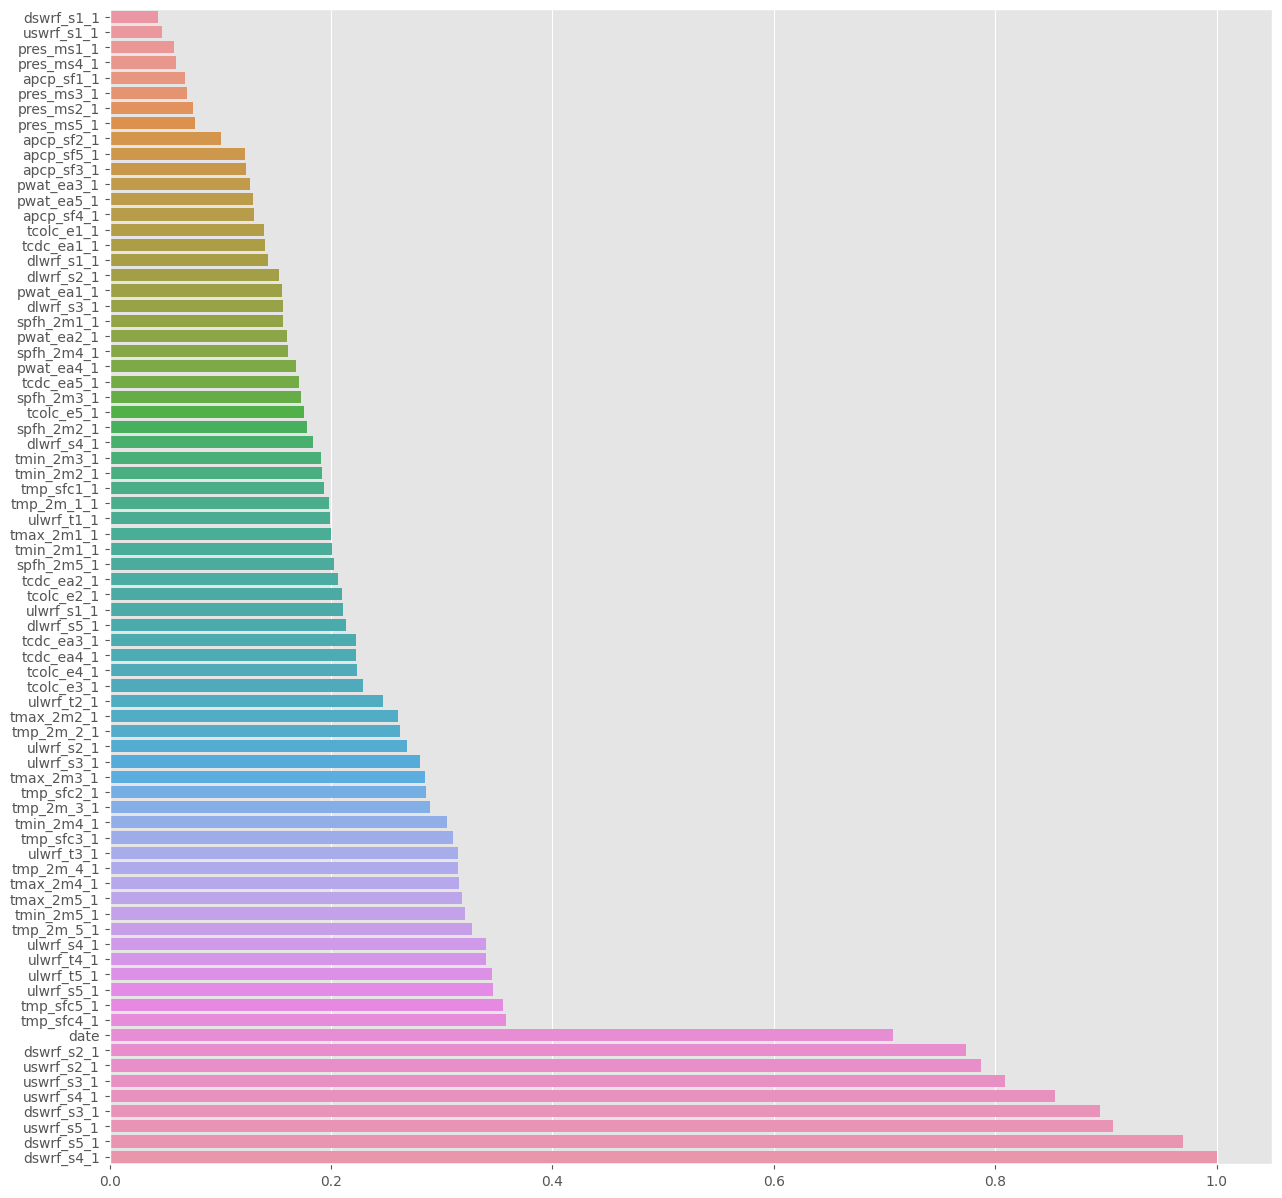

In [132]:
np.random.seed(random_seed)
random.seed(random_seed)

mi = mutual_info_regression(X_df, Y_df)
mi /= np.max(mi)

dep_vars = ['salida'] # Variable dependiente
indep_vars = disp_df.columns.difference(dep_vars).tolist() # Variables independientes

from sklearn.feature_selection import mutual_info_regression as mi_reg

df_mi = pd.DataFrame([mi_reg(disp_df[indep_vars], disp_df[dep_var]) for dep_var in dep_vars], index = dep_vars, columns = indep_vars).apply(lambda x: x / x.max(), axis = 1)

df_mi = df_mi.T

df_mi = df_mi.sort_values(by='salida')

df_mi = df_mi.T


f, ax = plt.subplots(figsize=(15, 15))
sns.barplot(df_mi, orient="h")

# Preparación de datasets para entrenamiento y test

En primer lugar separamos el dataset en entrenamiento y test, cogemos los primeros 10 años para entrenamiento y validación, y los últimos 2 años para test.

In [133]:
X_train, X_test = np.array_split(X_df, [3650])
y_train, y_test = np.array_split(Y_df, [3650])
# The indices which have the value -1 will be kept in train.
train_indices = np.full((2920,), -1, dtype=int) # 8 years
# The indices which have zero or positive values, will be kept in validation
val_indices = np.full((730,), 0, dtype=int) # 2 years
test_fold = np.append(train_indices, val_indices)

ps = PredefinedSplit(test_fold)

# Funciones auxiliares

In [134]:
def RMSE(y_test, y_test_pred):
  """ Cálculo del error cuadrático medio """
  return np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
def MAE(y_test, y_test_pred):
  """ Cálculo del error absoluto medio """
  return metrics.mean_absolute_error(y_test, y_test_pred)

In [135]:
def pintaResultados (reg, n):
  plt.subplots(figsize=(30, 5))
  x = np.arange(y_test[:n].size)
  pred = reg.predict(X=X_test)
  plt.plot(x, y_test[:n], 'b.', x, pred[:n], 'g^')

Apoyamos todo nuestro ajuste de hiperparámetros en esta función

Usamos `OptunaSearchCV`. Optuna se usa para la búsqueda de hiperparámetros y la función `OptunaSearchCV()` es de tipo experimental.

Combina búsqueda de hiperparámetros con optimizador bayesiano (busca en regiones prometedoras) y además elimina de forma temprana combinaciones de hiperparámetros que no superan a los anteriores (algoritmos evolutivos).

Consideramos este framework como esencial en nuestra práctica.

In [136]:
def evaluate(model, X, y, cv, fit_params=None, tune=False, metric="neg_mean_absolute_error", jobs=1):
    """
     Evalúa cualquier pipeline por validación cruzada.
     Tiene la capacidad de hace una estimación de hiperparámetros con algoritmos heurísticos.
     Tiempo máximo de ejecución 15 minutos en caso de ajuste
    """
    np.random.seed(random_seed)
    random.seed(random_seed)
    
    if not tune:
        cv_results = cross_validate(
            model,
            X,
            y,
            cv=cv,
            scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
            fit_params=fit_params,
            return_train_score=True,
            return_estimator=True,
            verbose=0,
            n_jobs=jobs
        )
        return cv_results
    else:
        optuna_search = OptunaSearchCV(estimator=model, 
                                        param_distributions=fit_params, 
                                        cv=cv,
                                        n_trials=200,
                                        timeout=600,
                                        scoring=metric,
                                        random_state=random_seed,
                                        verbose=0,
                                        n_jobs=jobs)
        optuna_search.fit(X, y)

        return optuna_search

# Modelos básicos

## Modelos básicos con hiperparámetros por defecto

### KNN

In [137]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_knn = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsRegressor())
    ])
start = time.time()
knn_default = evaluate(pipe_knn, X_train, y_train, cv=ps)
knn_default_time = time.time()-start
print("MAE de KNN por defecto en validación:", -knn_default["test_neg_mean_absolute_error"][0])
print("RMSE de KNN por defecto en validación:", -knn_default["test_neg_root_mean_squared_error"][0])

MAE de KNN por defecto en validación: 2470669.607671233
RMSE de KNN por defecto en validación: 3549126.8359597456


### Árboles de regresión

In [138]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_tree = Pipeline([
    ('tree', DecisionTreeRegressor(random_state=random_seed))
    ])

start = time.time()
tree_default = evaluate(pipe_tree, X_train, y_train, cv=ps, metric="neg_mean_absolute_error")
tree_default_time = time.time()-start

print("MAE de Árboles de regresión por defecto en validación:", -tree_default["test_neg_mean_absolute_error"][0])
print("RMSE de Árboles de regresión por defecto en validación:", -tree_default["test_neg_root_mean_squared_error"][0])

tree_default['estimator'][0]

MAE de Árboles de regresión por defecto en validación: 3020700.898630137
RMSE de Árboles de regresión por defecto en validación: 4473627.354295174


Pipeline(steps=[('tree', DecisionTreeRegressor(random_state=36))])

### Modelos lineales

#### Modelo de mínimos cuadrados ordinarios

Hacemos un ajuste de mínimos cuadrados ordinarios.

Esta técnica no requiere un ajuste de hiperparámetros

In [139]:
pipe_regr = Pipeline([
    ('scale', StandardScaler()),
    ('linear', LinearRegression())
    ])

start = time.time()
linear_default=evaluate(pipe_regr, X_train, y_train, cv=ps)
linear_default_time = time.time()-start

print("MAE de Modelo de mínimos cuadrados ordinarios en validación:", -linear_default["test_neg_mean_absolute_error"][0])
print("RMSE de Modelo de mínimos cuadrados ordinarios en validación:", -linear_default["test_neg_root_mean_squared_error"][0])

MAE de Modelo de mínimos cuadrados ordinarios en validación: 2109572.7692189086
RMSE de Modelo de mínimos cuadrados ordinarios en validación: 2998971.899503992


#### Modelo Ridge

In [140]:
pipe_ridge = Pipeline([
    ('scale', StandardScaler()),
    ('ridge', Ridge())
    ])

start = time.time()
ridge_default = evaluate(pipe_ridge, X_train, y_train, cv=ps)
ridge_default_time = time.time()-start

print("MAE de Ridge por defecto en validación:", -ridge_default["test_neg_mean_absolute_error"][0])
print("RMSE de Ridge por defecto en validación:", -ridge_default["test_neg_root_mean_squared_error"][0])

MAE de Ridge por defecto en validación: 2110893.6724101803
RMSE de Ridge por defecto en validación: 2998992.784108875


#### Modelo Lasso

In [141]:
pipe_lasso = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', Lasso())
    ])

start = time.time()
lasso_default = evaluate(pipe_lasso, X_train, y_train, cv=ps)
lasso_default_time = time.time()-start

print("MAE de Lasso por defecto en validación:", -lasso_default["test_neg_mean_absolute_error"][0])
print("RMSE de Lasso por defecto en validación:", -lasso_default["test_neg_root_mean_squared_error"][0])

MAE de Lasso por defecto en validación: 2134207.3901741686
RMSE de Lasso por defecto en validación: 3016551.910596079


#### Modelo ElasticNet

In [142]:
pipe_elastic = Pipeline([
    ('scale', StandardScaler()),
    ('elastic', ElasticNet())
    ])

start = time.time()
elastic_default = evaluate(pipe_elastic, X_train, y_train, cv=ps)
elastic_default_time = time.time()-start


print("MAE de ElasticNet por defecto en validación:", -elastic_default["test_neg_mean_absolute_error"][0])
print("RMSE de ElasticNet por defecto en validación:", -elastic_default["test_neg_root_mean_squared_error"][0])

MAE de ElasticNet por defecto en validación: 2411551.1067409967
RMSE de ElasticNet por defecto en validación: 3310135.366794845


### Comparación de modelos básicos con parámetros por defecto

El peor ha sido el modelo de árboles.

El modelo lineal lo ha hecho sorprendentemente bien.

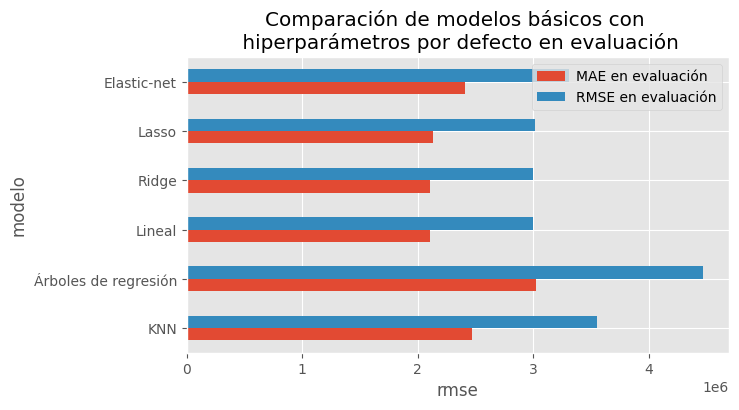

,modelo,MAE en evaluación,RMSE en evaluación
0,KNN,2.470670e+06,3.549127e+06
1,Árboles de regresión,3.020701e+06,4.473627e+06
2,Lineal,2.109573e+06,2.998972e+06
3,Ridge,2.110894e+06,2.998993e+06
4,Lasso,2.134207e+06,3.016552e+06
5,Elastic-net,2.411551e+06,3.310135e+06


In [143]:
mae_knn = -knn_default["test_neg_mean_absolute_error"][0]
mae_tree = -tree_default["test_neg_mean_absolute_error"][0]
mae_lineal = -linear_default["test_neg_mean_absolute_error"][0]
mae_ridge = -ridge_default["test_neg_mean_absolute_error"][0]
mae_lasso = -lasso_default["test_neg_mean_absolute_error"][0]
mae_elastic = -elastic_default["test_neg_mean_absolute_error"][0]

rmse_knn = -knn_default["test_neg_root_mean_squared_error"][0]
rmse_tree = -tree_default["test_neg_root_mean_squared_error"][0]
rmse_lineal = -linear_default["test_neg_root_mean_squared_error"][0]
rmse_ridge = -ridge_default["test_neg_root_mean_squared_error"][0]
rmse_lasso = -lasso_default["test_neg_root_mean_squared_error"][0]
rmse_elastic = -elastic_default["test_neg_root_mean_squared_error"][0]

df_comparacion = pd.DataFrame({
                    'modelo': ['KNN', 'Árboles de regresión', 'Lineal', 'Ridge', 'Lasso', 'Elastic-net'],
                    'MAE en evaluación': [mae_knn, mae_tree, mae_lineal, mae_ridge, mae_lasso, mae_elastic],
                    'RMSE en evaluación': [rmse_knn, rmse_tree, rmse_lineal, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos básicos con \n hiperparámetros por defecto en evaluación')
plt.show()

df_comparacion

Los tiempos de entrenamiento han sido inferiores a un segundo en todos

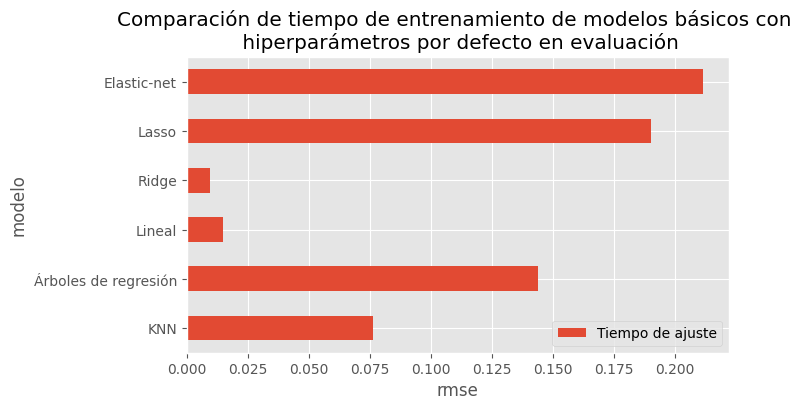

,modelo,Tiempo de ajuste
0,KNN,0.076274
1,Árboles de regresión,0.144050
2,Lineal,0.015035
3,Ridge,0.009623
4,Lasso,0.189985
5,Elastic-net,0.211605


In [144]:
df_comparacion = pd.DataFrame({
                    'modelo': ['KNN', 'Árboles de regresión', 'Lineal', 'Ridge', 'Lasso', 'Elastic-net'],
                    'Tiempo de ajuste': [knn_default_time, tree_default_time, linear_default_time, ridge_default_time, lasso_default_time, elastic_default_time],
                 })

fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de tiempo de entrenamiento de modelos básicos con \n hiperparámetros por defecto en evaluación')
plt.show()

df_comparacion

## Modelos básicos con hiperparámetros ajustados

### KNN

Parámetros a ajustar

In [145]:
fit_params={
    'knn__n_neighbors': IntDistribution(1, 200),
    'knn__weights' : CategoricalDistribution(['uniform','distance']),
    'knn__metric' : CategoricalDistribution(['minkowski','euclidean','manhattan'])
}

In [146]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_knn = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsRegressor())
    ])

start = time.time()
knn_mae_tuned = evaluate(pipe_knn, X_train, y_train, cv=ps, fit_params=fit_params, tune=True, metric="neg_mean_absolute_error", jobs=-1)
knn_mae_tuned_time = time.time() - start

knn_mae_tuned.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('knn',
                 KNeighborsRegressor(metric='manhattan', n_neighbors=15,
                                     weights='distance'))])

In [147]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_knn = Pipeline([
    ('scale', StandardScaler()),
    ('knn', KNeighborsRegressor())
    ])

start = time.time()
knn_rmse_tuned = evaluate(pipe_knn, X_train, y_train, cv=ps, fit_params=fit_params, tune=True, metric="neg_root_mean_squared_error", jobs=-1)
knn_rmse_tuned_time = time.time() - start

knn_rmse_tuned.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('knn',
                 KNeighborsRegressor(metric='manhattan', n_neighbors=17,
                                     weights='distance'))])

In [148]:
print("MAE de KNN con hiperparámetros ajustados en validación: ", -knn_mae_tuned.best_score_)
print("RMSE de KNN con hiperparámetros ajustados en validación: ", -knn_rmse_tuned.best_score_)

MAE de KNN con hiperparámetros ajustados en validación:  2314925.185145454
RMSE de KNN con hiperparámetros ajustados en validación:  3327851.5243573957


### Árboles de regresión

In [149]:
fit_params={
    'tree__criterion': CategoricalDistribution(['squared_error', 'friedman_mse', 'absolute_error', 'poisson']),
    'tree__max_depth': IntDistribution(1, 200),
    'tree__min_samples_split': IntDistribution(2, 200),
    'tree__min_samples_leaf': IntDistribution(2, 200),
    'tree__max_features': IntDistribution(1, 77),
    'tree__max_leaf_nodes': IntDistribution(2, 200)
}

In [150]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_tree = Pipeline([
    ('tree', DecisionTreeRegressor(random_state=random_seed))
    ])

start = time.time()
tree_mae_tuned = evaluate(pipe_tree, X_train, y_train, cv=ps, fit_params=fit_params, tune=True, metric="neg_mean_absolute_error", jobs=-1)
tree_mae_tuned_time = time.time() - start

tree_mae_tuned.best_estimator_

Pipeline(steps=[('tree',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=99,
                                       max_features=36, max_leaf_nodes=70,
                                       min_samples_leaf=18,
                                       min_samples_split=65,
                                       random_state=36))])

In [151]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_tree = Pipeline([
    ('tree', DecisionTreeRegressor(random_state=random_seed))
    ])

start = time.time()
tree_rmse_tuned = evaluate(pipe_tree, X_train, y_train, cv=ps, fit_params=fit_params, tune=True, metric="neg_root_mean_squared_error", jobs=-1)
tree_rmse_tuned_time = time.time() - start

tree_rmse_tuned.best_estimator_

Pipeline(steps=[('tree',
                 DecisionTreeRegressor(criterion='friedman_mse', max_depth=33,
                                       max_features=23, max_leaf_nodes=107,
                                       min_samples_leaf=34,
                                       min_samples_split=26,
                                       random_state=36))])

In [152]:
print("MAE de Árboles de regresión con hiperparámetros ajustados en validación: ", -tree_mae_tuned.best_score_)
print("RMSE de Árboles de regresión con hiperparámetros ajustados en validación: ", -tree_rmse_tuned.best_score_)

MAE de Árboles de regresión con hiperparámetros ajustados en validación:  2253084.8630136987
RMSE de Árboles de regresión con hiperparámetros ajustados en validación:  3397374.6144965705


### Modelos lineales

#### Modelo Ridge

In [153]:
fit_params={
    'ridge__alpha': FloatDistribution(10e-5, 10e8, log=True)
}

In [154]:

np.random.seed(random_seed)
random.seed(random_seed)
pipe_ridge = Pipeline([
    ('scale', StandardScaler()),
    ('ridge', Ridge(random_state=random_seed))
    ])

start = time.time()
ridge_mae_tuned = evaluate(pipe_ridge, X_train, y_train, cv=ps, fit_params=fit_params, tune=True, metric="neg_mean_absolute_error", jobs=-1)
ridge_mae_tuned_time = time.time() - start

ridge_mae_tuned.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('ridge', Ridge(alpha=0.07717321846003955, random_state=36))])

In [155]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_ridge = Pipeline([
    ('scale', StandardScaler()),
    ('ridge', Ridge(random_state=random_seed))
    ])

start = time.time()
ridge_rmse_tuned = evaluate(pipe_ridge, X_train, y_train, cv=ps, fit_params=fit_params, tune=True, metric="neg_root_mean_squared_error", jobs=-1)
ridge_rmse_tuned_time = time.time() - start

ridge_rmse_tuned.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('ridge', Ridge(alpha=0.1785242039172092, random_state=36))])

In [156]:
print("MAE de Ridge con hiperparámetros ajustados en validación: ", -ridge_mae_tuned.best_score_)
print("RMSE de Ridge con hiperparámetros ajustados en validación: ", -ridge_rmse_tuned.best_score_)

MAE de Ridge con hiperparámetros ajustados en validación:  2105512.1091328347
RMSE de Ridge con hiperparámetros ajustados en validación:  2993342.256499491


#### Modelo Lasso

In [157]:
fit_params={
    'lasso__alpha': FloatDistribution(10e-5, 10e8, log=True)
}

In [158]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_lasso = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', Lasso(random_state=random_seed))
    ])

start = time.time()
lasso_mae_tuned = evaluate(pipe_lasso, X_train, y_train, cv=ps, fit_params=fit_params, tune=True, metric="neg_mean_absolute_error", jobs=-1)
lasso_mae_tuned_time = time.time() - start

lasso_mae_tuned.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('lasso', Lasso(alpha=2034.750219306028, random_state=36))])

In [159]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_lasso = Pipeline([
    ('scale', StandardScaler()),
    ('lasso', Lasso(random_state=random_seed))
    ])

start = time.time()
lasso_rmse_tuned = evaluate(pipe_lasso, X_train, y_train, cv=ps, fit_params=fit_params, tune=True, metric="neg_root_mean_squared_error", jobs=-1)
lasso_rmse_tuned_time = time.time() - start

lasso_rmse_tuned.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('lasso', Lasso(alpha=936.5997955386686, random_state=36))])

In [160]:
print("MAE de Lasso con hiperparámetros ajustados en validación: ", -lasso_mae_tuned.best_score_)
print("RMSE de Lasso con hiperparámetros ajustados en validación: ", -lasso_rmse_tuned.best_score_)

MAE de Lasso con hiperparámetros ajustados en validación:  2126733.4015743393
RMSE de Lasso con hiperparámetros ajustados en validación:  3015830.4919485254


#### Modelo ElasticNet

In [161]:
fit_params={
    'elastic__l1_ratio': FloatDistribution(0, 1),
    'elastic__alpha': FloatDistribution(10e-5, 10e8, log=True)
}

In [162]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_elastic = Pipeline([
    ('scale', StandardScaler()),
    ('elastic', ElasticNet(random_state=random_seed))
    ])

start = time.time()
elastic_mae_tuned = evaluate(pipe_elastic, X_train, y_train, cv=ps, fit_params=fit_params, tune=True, metric="neg_mean_absolute_error", jobs=-1)
elastic_mae_tuned_time = time.time() - start

elastic_mae_tuned.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('elastic',
                 ElasticNet(alpha=0.002006849850886954,
                            l1_ratio=0.1780842490314937, random_state=36))])

In [163]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_elastic = Pipeline([
    ('scale', StandardScaler()),
    ('elastic', ElasticNet(random_state=random_seed))
    ])

start = time.time()
elastic_rmse_tuned = evaluate(pipe_elastic, X_train, y_train, cv=ps, fit_params=fit_params, tune=True, metric="neg_root_mean_squared_error", jobs=-1)
elastic_rmse_tuned_time = time.time() - start

elastic_rmse_tuned.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('elastic',
                 ElasticNet(alpha=0.002753799362156753,
                            l1_ratio=0.9775684573070824, random_state=36))])

In [164]:
print("MAE de ElasticNet con hiperparámetros ajustados en validación: ", -elastic_mae_tuned.best_score_)
print("RMSE de ElasticNet con hiperparámetros ajustados en validación: ", -elastic_rmse_tuned.best_score_)

MAE de ElasticNet con hiperparámetros ajustados en validación:  2125647.867490668
RMSE de ElasticNet con hiperparámetros ajustados en validación:  3016529.0600701994


Búsqueda de hiperparámetros para un modelo polinómico. No incluido por el larguísimo tiempo de ejecución

In [165]:
'''
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score 

degrees = [1, 2, 3, 4] # Change degree "hyperparameter" here
best_score = 0
best_degree = 0
for degree in degrees:
    poly_features = PolynomialFeatures(degree = degree, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train)
    polynomial_regressor = LinearRegression()
    polynomial_regressor.fit(X_train_poly, y_train)
    scores = cross_val_score(polynomial_regressor, X_train_poly, y_train, cv=3) # Change k-fold cv value here
    if max(scores) > best_score:
      best_score = max(scores)
      best_degree = degree

print(f"Mejor valor (R2): {best_score}")
print(f"Mejor valor de grado encontrado: {best_degree}")

poly_features = PolynomialFeatures(degree = best_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
best_polynomial_regressor = LinearRegression()
best_polynomial_regressor.fit(X_train_poly, y_train)
X_test_poly = poly_features.fit_transform(X_test)
print(f"RMSE de regresión polinomial: {rmse(y_test, best_polynomial_regressor.predict(X=X_test_poly))}")
plt.subplots(figsize=(30, 5))
x = np.arange(y_test[:50].size)
y_pred = best_polynomial_regressor.predict(X=X_test_poly)
plt.plot(x, y_test[:50], 'b.', x, y_pred[:50], 'g^')
'''

'\nfrom sklearn.linear_model import LinearRegression\nfrom sklearn.preprocessing import PolynomialFeatures\nfrom sklearn.model_selection import cross_val_score \n\ndegrees = [1, 2, 3, 4] # Change degree "hyperparameter" here\nbest_score = 0\nbest_degree = 0\nfor degree in degrees:\n    poly_features = PolynomialFeatures(degree = degree, include_bias=False)\n    X_train_poly = poly_features.fit_transform(X_train)\n    polynomial_regressor = LinearRegression()\n    polynomial_regressor.fit(X_train_poly, y_train)\n    scores = cross_val_score(polynomial_regressor, X_train_poly, y_train, cv=3) # Change k-fold cv value here\n    if max(scores) > best_score:\n      best_score = max(scores)\n      best_degree = degree\n\nprint(f"Mejor valor (R2): {best_score}")\nprint(f"Mejor valor de grado encontrado: {best_degree}")\n\npoly_features = PolynomialFeatures(degree = best_degree, include_bias=False)\nX_train_poly = poly_features.fit_transform(X_train)\nbest_polynomial_regressor = LinearRegressio

## Comparación / conclusiones de modelos básicos

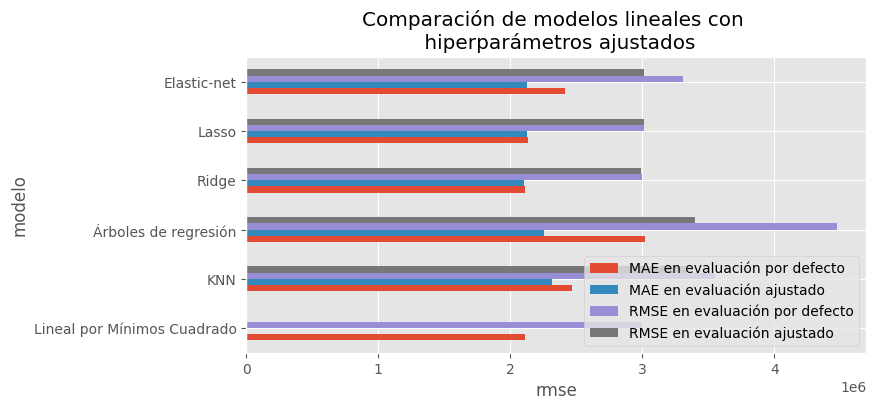

,modelo,MAE en evaluación por defecto,MAE en evaluación ajustado,RMSE en evaluación por defecto,RMSE en evaluación ajustado
0,Lineal por Mínimos Cuadrado,2.109573e+06,0.000000e+00,2.998972e+06,0.000000e+00
1,KNN,2.470670e+06,2.314925e+06,3.549127e+06,3.327852e+06
2,Árboles de regresión,3.020701e+06,2.253085e+06,4.473627e+06,3.397375e+06
3,Ridge,2.110894e+06,2.105512e+06,2.998993e+06,2.993342e+06
4,Lasso,2.134207e+06,2.126733e+06,3.016552e+06,3.015830e+06
5,Elastic-net,2.411551e+06,2.125648e+06,3.310135e+06,3.016529e+06


In [ ]:
mae_knn_default = -knn_default["test_neg_mean_absolute_error"][0]
mae_tree_default = -tree_default["test_neg_mean_absolute_error"][0]
mae_lineal_default = -linear_default["test_neg_mean_absolute_error"][0]
mae_ridge_default = -ridge_default["test_neg_mean_absolute_error"][0]
mae_lasso_default = -lasso_default["test_neg_mean_absolute_error"][0]
mae_elastic_default = -elastic_default["test_neg_mean_absolute_error"][0]

rmse_knn_default = -knn_default["test_neg_root_mean_squared_error"][0]
rmse_tree_default = -tree_default["test_neg_root_mean_squared_error"][0]
rmse_lineal_default = -linear_default["test_neg_root_mean_squared_error"][0]
rmse_ridge_default = -ridge_default["test_neg_root_mean_squared_error"][0]
rmse_lasso_default = -lasso_default["test_neg_root_mean_squared_error"][0]
rmse_elastic_default = -elastic_default["test_neg_root_mean_squared_error"][0]

mae_knn_tuned = -knn_mae_tuned.best_score_
mae_tree_tuned = -tree_mae_tuned.best_score_
mae_ridge_tuned = -ridge_mae_tuned.best_score_
mae_lasso_tuned = -lasso_mae_tuned.best_score_
mae_elastic_tuned = -elastic_mae_tuned.best_score_

rmse_knn_tuned = -knn_rmse_tuned.best_score_
rmse_tree_tuned = -tree_rmse_tuned.best_score_
rmse_ridge_tuned = -ridge_rmse_tuned.best_score_
rmse_lasso_tuned = -lasso_rmse_tuned.best_score_
rmse_elastic_tuned = -elastic_rmse_tuned.best_score_

df_comparacion = pd.DataFrame({
                    'modelo': ['Lineal por Mínimos Cuadrado', 'KNN', 'Árboles de regresión', 'Ridge', 'Lasso', 'Elastic-net'],
                    'MAE en evaluación por defecto': [mae_lineal_default, mae_knn_default, mae_tree_default, mae_ridge_default, mae_lasso_default, mae_elastic_default],
                    'MAE en evaluación ajustado': [0, mae_knn_tuned, mae_tree_tuned, mae_ridge_tuned, mae_lasso_tuned, mae_elastic_tuned],
                    'RMSE en evaluación por defecto': [rmse_lineal_default, rmse_knn_default, rmse_tree_default, rmse_ridge_default, rmse_lasso_default, rmse_elastic_default],
                    'RMSE en evaluación ajustado': [0, rmse_knn_tuned, rmse_tree_tuned, rmse_ridge_tuned, rmse_lasso_tuned, rmse_elastic_tuned]
                 })

fig, ax = plt.subplots(figsize=(8, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('error')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos lineales con \n hiperparámetros ajustados')
plt.show()

df_comparacion

Tiempos de ajuste

Los árboles han sido los peores

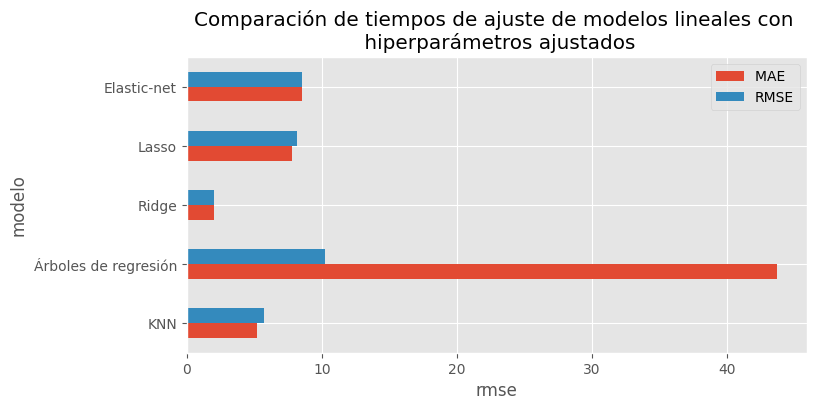

,modelo,MAE,RMSE
0,KNN,5.237983,5.713499
1,Árboles de regresión,43.701029,10.250621
2,Ridge,1.992938,2.034324
3,Lasso,7.823919,8.184579
4,Elastic-net,8.509955,8.544537


In [167]:
df_comparacion = pd.DataFrame({
                    'modelo': ['KNN', 'Árboles de regresión', 'Ridge', 'Lasso', 'Elastic-net'],
                    'MAE ': [knn_mae_tuned_time, tree_mae_tuned_time, ridge_mae_tuned_time, lasso_mae_tuned_time, elastic_mae_tuned_time],
                    'RMSE': [knn_rmse_tuned_time, tree_rmse_tuned_time, ridge_rmse_tuned_time, lasso_rmse_tuned_time, elastic_rmse_tuned_time]
                 })

fig, ax = plt.subplots(figsize=(8, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de tiempos de ajuste de modelos lineales con \n hiperparámetros ajustados')
plt.show()

df_comparacion

## Conclusiones

Dado su bajo tiempo de ajuste y rendimiento similar consideramos a Ridge como el mejor modelo lineal en este caso.

En cuanto a comparativas, observamos que el modelo naive (mínimos cuadrados ordinarios) tiene un rendimiento similar a los modelos ajustados por lo que concluimos que los modelos hasta ahora probados no son suficientemente buenos.

El tiempo de ejecución es peor para todos los modelos ajustados respecto al naive. Además un mayor tiempo de búsqueda no ha resultado en una mejora de los resultados.

# Reducción de la dimensionalidad

En nuestro caso sí creemos posible una reducción de la dimensionalidad, haciendo el siguiente razonamiento:
La variable salida mide la radiación acumulada del día. En términos físicos, está midiendo la cantidad de trabajo aportada del sistema a la placa. (en el sistema sol placa). Las placas solares generan energía de la radiación por lo que la cantidad de trabajo será la cantidad de radiación por el tiempo.

Es decir se podría realizar una integral de Riemman sobre las particiones de la variable tiempo (t) sabiendo que las predicciones son en t=12, 15, 18, 21, 24h (trabajo es fuerza por diferencial de tiempo) para medir la radiación acumulada y reducir la cantidad de variables de 5 de un tipo a 1.

Por otra parte se podrían eliminar aquellas variables con varianza baja (menor al 5% ) y aquellas con una MutualInformation menor a 0,5. Es decir aquellas que no cumplan los dos criterios se eliminan

# Modelos avanzados

## Modelos avanzados con hiperparámetros por defecto

### SVM

In [168]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_svr = Pipeline([
    ('scale', StandardScaler()),
    ('svr', SVR())
    ])

start = time.time()
svr_default = evaluate(pipe_svr, X_train, y_train, cv=ps)
svr_default_time = time.time() - start

svr_default

{'fit_time': array([0.37111187]),
 'score_time': array([0.23733306]),
 'estimator': [Pipeline(steps=[('scale', StandardScaler()), ('svr', SVR())])],
 'test_neg_mean_absolute_error': array([-6784907.68757811]),
 'train_neg_mean_absolute_error': array([-6862119.41361242]),
 'test_neg_root_mean_squared_error': array([-7893664.8778298]),
 'train_neg_root_mean_squared_error': array([-8008901.86305746])}

In [169]:
print("MAE de SVM con hiperparámetros por defecto en validación:", -svr_default["test_neg_mean_absolute_error"][0])
print("RMSE de SVM con hiperparámetros por defecto en validación:", -svr_default["test_neg_root_mean_squared_error"][0])

MAE de SVM con hiperparámetros por defecto en validación: 6784907.687578115
RMSE de SVM con hiperparámetros por defecto en validación: 7893664.877829804


### Random Forests

In [170]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_rf = Pipeline([
    ('rf', RandomForestRegressor())
    ])

start = time.time()
rf_default = evaluate(pipe_rf, X_train, y_train, cv=ps)
rf_default_time = time.time() - start

rf_default

{'fit_time': array([8.41893601]),
 'score_time': array([0.01299214]),
 'estimator': [Pipeline(steps=[('rf', RandomForestRegressor())])],
 'test_neg_mean_absolute_error': array([-2184057.21320548]),
 'train_neg_mean_absolute_error': array([-807238.82080822]),
 'test_neg_root_mean_squared_error': array([-3179437.85696706]),
 'train_neg_root_mean_squared_error': array([-1215895.4400931])}

In [171]:
print("MAE de Random Forest con hiperparámetros por defecto en validación:", -rf_default["test_neg_mean_absolute_error"][0])
print("RMSE de Random Forest con hiperparámetros por defecto en validación:", -rf_default["test_neg_root_mean_squared_error"][0])

MAE de Random Forest con hiperparámetros por defecto en validación: 2184057.213205479
RMSE de Random Forest con hiperparámetros por defecto en validación: 3179437.856967056


### XGBoost

In [172]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_xgboost = Pipeline([
    ('xgboost', XGBRegressor())
    ])

start = time.time()
xgboost_default = evaluate(pipe_xgboost, X_train, y_train, cv=ps)
xgboost_default_time = time.time() - start

xgboost_default

{'fit_time': array([7.5782032]),
 'score_time': array([0.0066781]),
 'estimator': [Pipeline(steps=[('xgboost',
                   XGBRegressor(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None, gpu_id=None,
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None, learning_rate=None,
                                max_bin=None, max_cat_threshold=None,
                                max_cat_to_onehot=None, max_delta_step=None,
                                max_depth=None, max_leaves=None,
                                min_child_weight=None, missing=nan,
                                monotone_constraints=None, n_

In [173]:
print("MAE de XGBoost con hiperparámetros por defecto en validación:", -xgboost_default["test_neg_mean_absolute_error"][0])
print("RMSE de XGBoost con hiperparámetros por defecto en validación:", -xgboost_default["test_neg_root_mean_squared_error"][0])

MAE de XGBoost con hiperparámetros por defecto en validación: 2297954.3778253426
RMSE de XGBoost con hiperparámetros por defecto en validación: 3326450.71469027


## Modelos avanzados con hiperparámetros ajustados

### SVM

In [174]:
fit_params={
    'svr__kernel': CategoricalDistribution(['linear', 'rbf']),
    'svr__C': FloatDistribution(10e-3, 10e6, log=True),
    'svr__gamma': FloatDistribution(10e-4, 10e1, log=True),
    'svr__epsilon': FloatDistribution(10e-3, 10e0, log=True),
}

In [175]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_svr = Pipeline([
    ('scale', StandardScaler()),
    ('svr', SVR(cache_size=512))
    ])

start = time.time()
svr_mae_tuned = evaluate(pipe_svr, X_train, y_train, cv=ps, fit_params=fit_params, tune=True, metric="neg_mean_absolute_error", jobs=-1)
svr_mae_tuned_time = time.time() - start

svr_mae_tuned.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('svr',
                 SVR(C=9895113.429707853, cache_size=512,
                     epsilon=0.35452777466521684,
                     gamma=0.004918573655118058))])

<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

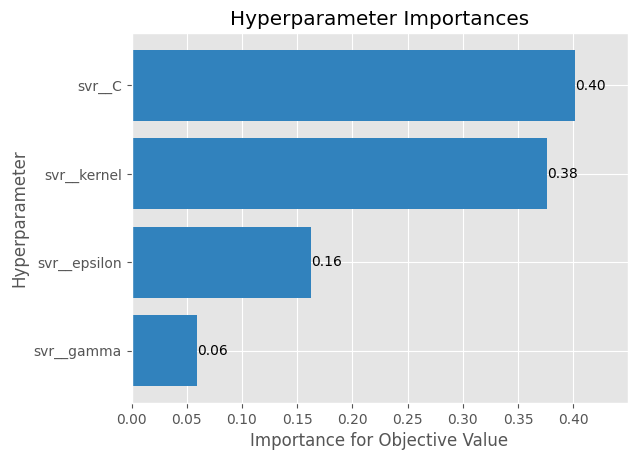

In [176]:
plot_param_importances(svr_mae_tuned.study_)

In [177]:
print(svr_mae_tuned.best_estimator_[1].get_params()['kernel'])
print(svr_mae_tuned.best_estimator_[1].get_params()['C'])
print(svr_mae_tuned.best_estimator_[1].get_params()['gamma'])
print(svr_mae_tuned.best_estimator_[1].get_params()['epsilon'])

rbf
9895113.429707853
0.004918573655118058
0.35452777466521684


[W 2023-04-14 22:35:27,901] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
[W 2023-04-14 22:35:27,985] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
[W 2023-04-14 22:35:28,059] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<Axes: title={'center': 'Contour Plot'}, xlabel='svr__C', ylabel='svr__gamma'>

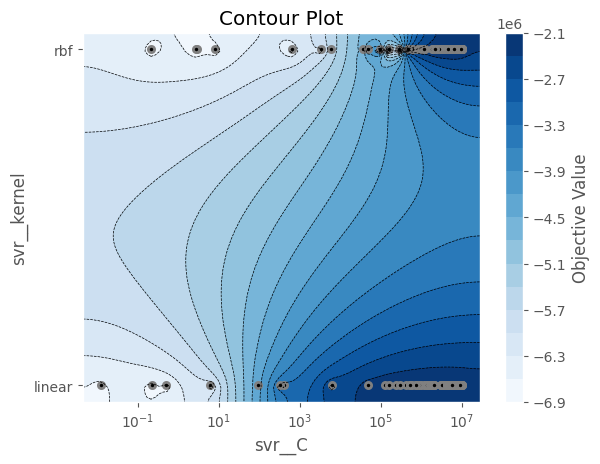

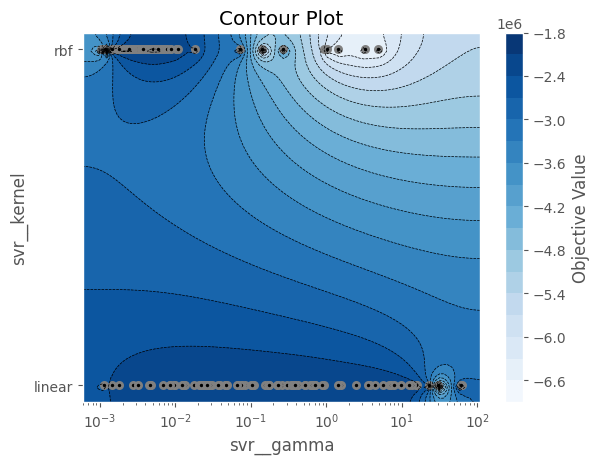

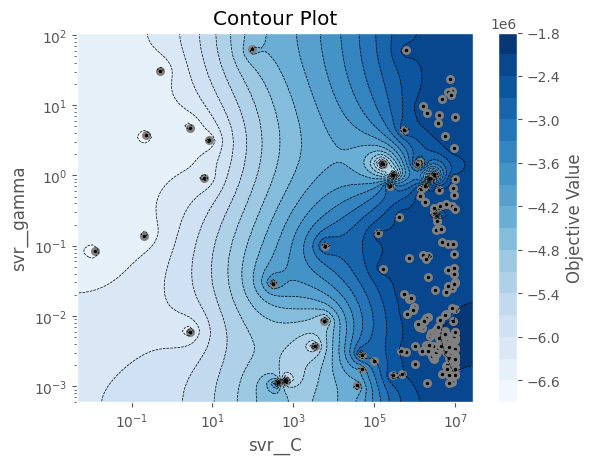

In [178]:
plot_contour(svr_mae_tuned.study_, params=['svr__kernel', 'svr__C'])
plot_contour(svr_mae_tuned.study_, params=['svr__kernel', 'svr__gamma'])
plot_contour(svr_mae_tuned.study_, params=['svr__C', 'svr__gamma'])

In [179]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_svr = Pipeline([
    ('scale', StandardScaler()),
    ('svr', SVR(cache_size=512))
    ])

start = time.time()
svr_rmse_tuned = evaluate(pipe_svr, X_train, y_train, cv=ps, fit_params=fit_params, tune=True, metric="neg_root_mean_squared_error", jobs=-1)
svr_rmse_tuned_time = time.time() - start

svr_rmse_tuned.best_estimator_

Pipeline(steps=[('scale', StandardScaler()),
                ('svr',
                 SVR(C=9935257.90044795, cache_size=512,
                     epsilon=1.2369342528275271, gamma=0.3673309408630221,
                     kernel='linear'))])

<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

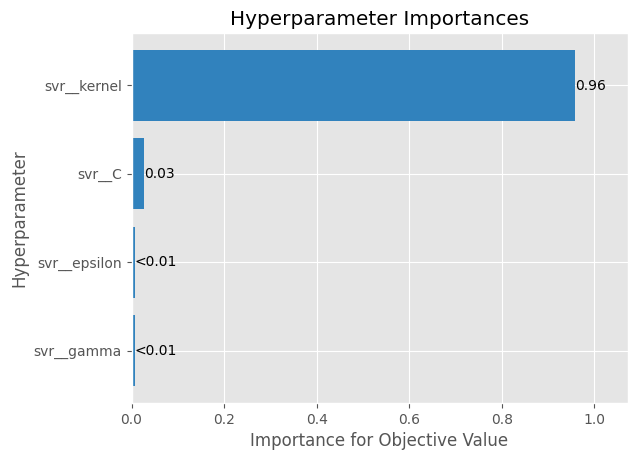

In [180]:
plot_param_importances(svr_rmse_tuned.study_)

In [181]:
print(svr_rmse_tuned.best_estimator_[1].get_params()['kernel'])
print(svr_rmse_tuned.best_estimator_[1].get_params()['C'])
print(svr_rmse_tuned.best_estimator_[1].get_params()['gamma'])
print(svr_rmse_tuned.best_estimator_[1].get_params()['epsilon'])

linear
9935257.90044795
0.3673309408630221
1.2369342528275271


[W 2023-04-14 22:46:21,801] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
[W 2023-04-14 22:46:21,870] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
[W 2023-04-14 22:46:21,937] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<Axes: title={'center': 'Contour Plot'}, xlabel='svr__C', ylabel='svr__gamma'>

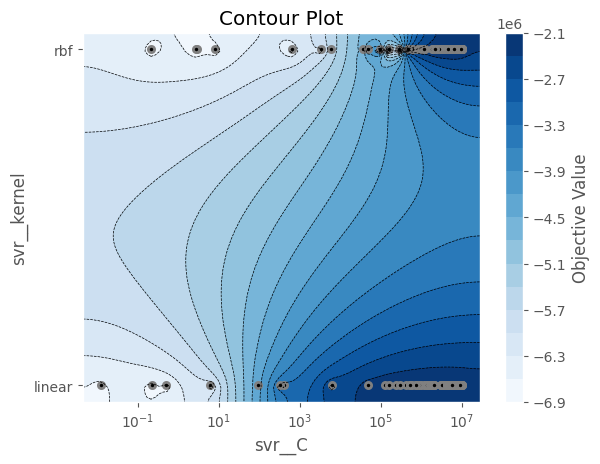

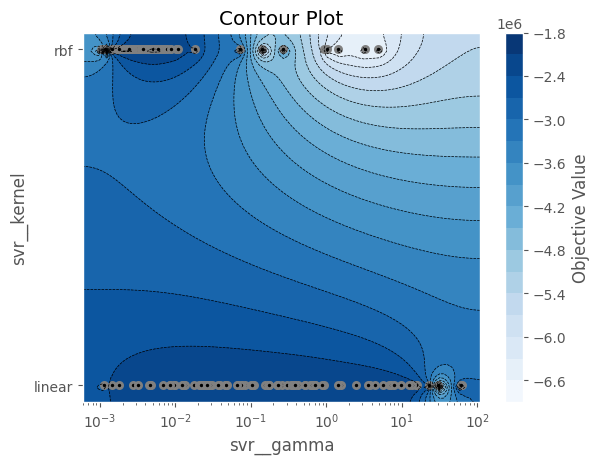

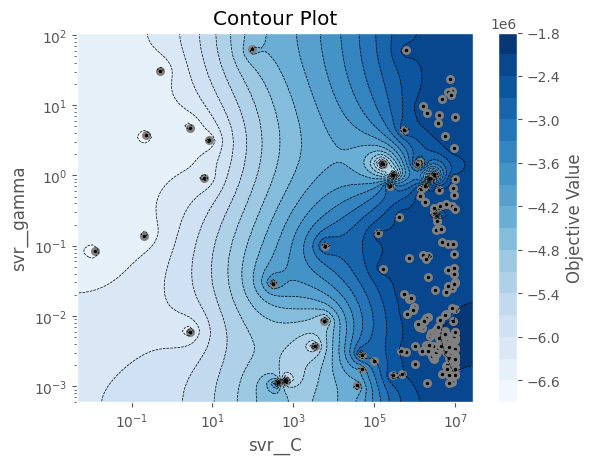

In [182]:
plot_contour(svr_mae_tuned.study_, params=['svr__kernel', 'svr__C'])
plot_contour(svr_mae_tuned.study_, params=['svr__kernel', 'svr__gamma'])
plot_contour(svr_mae_tuned.study_, params=['svr__C', 'svr__gamma'])

In [183]:
print(svr_rmse_tuned.best_estimator_[1].get_params()['kernel'])
print(svr_rmse_tuned.best_estimator_[1].get_params()['C'])
print(svr_rmse_tuned.best_estimator_[1].get_params()['gamma'])
print(svr_rmse_tuned.best_estimator_[1].get_params()['epsilon'])

linear
9935257.90044795
0.3673309408630221
1.2369342528275271


In [184]:
print("MAE de SVM con hiperparámetros ajustados en validación: ", -svr_mae_tuned.best_score_)
print("RMSE de SVM con hiperparámetros ajustados en validación: ", -svr_rmse_tuned.best_score_)

MAE de SVM con hiperparámetros ajustados en validación:  2072019.2666016547
RMSE de SVM con hiperparámetros ajustados en validación:  3183252.8825681233


### Random Forests

In [185]:
fit_params={
    'rf__n_estimators': IntDistribution(50, 500, 50),
    'rf__max_depth': IntDistribution(1, 200),
    'rf__min_samples_split': IntDistribution(2, 10),
    'rf__min_samples_leaf': IntDistribution(1, 10),
    'rf__max_features': IntDistribution(1, X_train.shape[1]+1)
}

In [ ]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_rf = Pipeline([
    ('rf', RandomForestRegressor(criterion="absolute_error", random_state=random_seed))
    ])

start = time.time()
rf_mae_tuned = evaluate(pipe_rf, X_train, y_train, cv=ps, fit_params=fit_params, tune=True, metric="neg_mean_absolute_error", jobs=-1)
rf_mae_tuned_time = time.time() - start

rf_mae_tuned.best_estimator_

<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

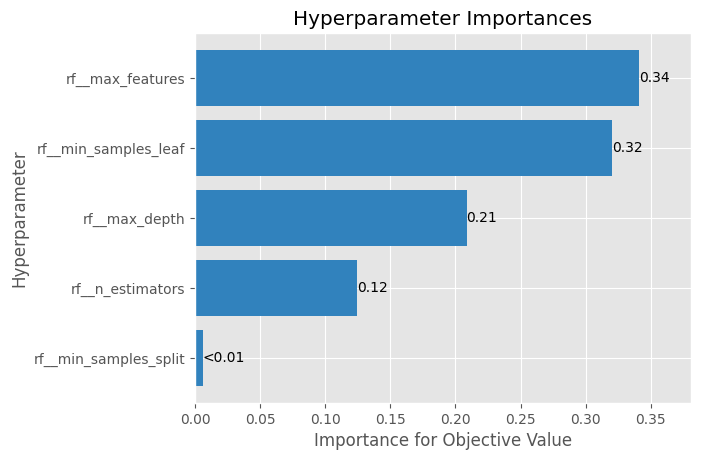

In [ ]:
plot_param_importances(rf_mae_tuned.study_)

In [ ]:
print(rf_mae_tuned.best_estimator_.get_params()['rf__n_estimators'])
print(rf_mae_tuned.best_estimator_.get_params()['rf__max_depth'])
print(rf_mae_tuned.best_estimator_.get_params()['rf__min_samples_split'])
print(rf_mae_tuned.best_estimator_.get_params()['rf__min_samples_leaf'])
print(rf_mae_tuned.best_estimator_.get_params()['rf__max_features'])

373
120
4
5
18


In [ ]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_rf = Pipeline([
    ('rf', RandomForestRegressor(criterion="squared_error", random_state=random_seed))
    ])

start = time.time()
rf_rmse_tuned = evaluate(pipe_rf, X_train, y_train, cv=ps, fit_params=fit_params, tune=True, metric="neg_root_mean_squared_error", jobs=-1)
rf_rmse_tuned_time = time.time() - start
rf_rmse_tuned.best_estimator_

[I 2023-04-12 20:54:56,239] A new study created in memory with name: no-name-7ab8edc9-15ee-4a03-8d01-cb3e01db5bed
[I 2023-04-12 20:54:58,693] Trial 5 finished with value: -3172374.6545695914 and parameters: {'rf__n_estimators': 58, 'rf__max_depth': 159, 'rf__min_samples_split': 3, 'rf__min_samples_leaf': 2, 'rf__max_features': 26}. Best is trial 5 with value: -3172374.6545695914.
[I 2023-04-12 20:55:01,432] Trial 4 finished with value: -3118999.0997272525 and parameters: {'rf__n_estimators': 284, 'rf__max_depth': 173, 'rf__min_samples_split': 3, 'rf__min_samples_leaf': 4, 'rf__max_features': 12}. Best is trial 4 with value: -3118999.0997272525.
[I 2023-04-12 20:55:01,922] Trial 3 finished with value: -3195279.2805223516 and parameters: {'rf__n_estimators': 79, 'rf__max_depth': 84, 'rf__min_samples_split': 3, 'rf__min_samples_leaf': 5, 'rf__max_features': 56}. Best is trial 4 with value: -3118999.0997272525.
[I 2023-04-12 20:55:02,873] Trial 7 finished with value: -3109920.734558786 and

Pipeline(steps=[('rf',
                 RandomForestRegressor(max_depth=110, max_features=5,
                                       min_samples_leaf=2, min_samples_split=4,
                                       n_estimators=347, random_state=36))])

<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

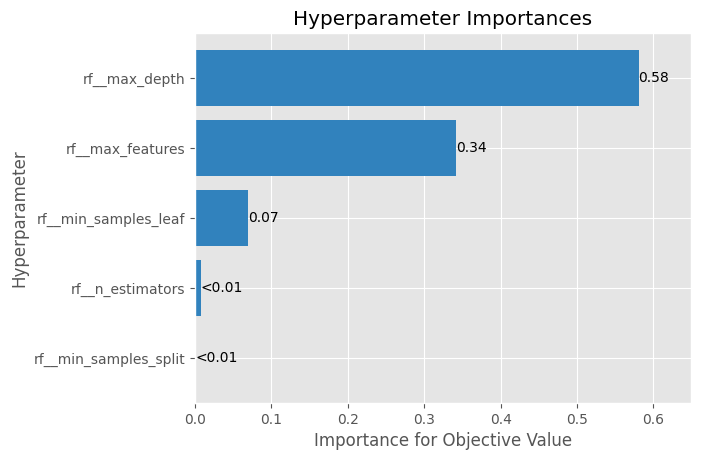

In [ ]:
plot_param_importances(rf_rmse_tuned.study_)

In [ ]:
print(rf_rmse_tuned.best_estimator_.get_params()['rf__n_estimators'])
print(rf_rmse_tuned.best_estimator_.get_params()['rf__max_depth'])
print(rf_rmse_tuned.best_estimator_.get_params()['rf__min_samples_split'])
print(rf_rmse_tuned.best_estimator_.get_params()['rf__min_samples_leaf'])
print(rf_rmse_tuned.best_estimator_.get_params()['rf__max_features'])

347
110
4
2
5


In [ ]:
print("MAE de Random Forest con hiperparámetros ajustados en validación: ", -rf_mae_tuned.best_score_)
print("RMSE de Random Forest con hiperparámetros ajustados en validación: ", -rf_rmse_tuned.best_score_)

MAE de Random Forest con hiperparámetros ajustados en validación:  2132281.631385655
RMSE de Random Forest con hiperparámetros ajustados en validación:  3087964.575109441


### XGBoost

In [ ]:
fit_params={
    'xgboost__learning_rate': FloatDistribution(0, 1),
    'xgboost__gamma': FloatDistribution(10e-3, 10e3, log=True),
    'xgboost__max_depth': IntDistribution(1, 10),
    'xgboost__min_child_weight': IntDistribution(0, 10),
    'xgboost__subsample': FloatDistribution(0, 1),
    'xgboost__lambda': FloatDistribution(10e-3, 10e3, log=True),
    'xgboost__alpha': FloatDistribution(10e-3, 10e3, log=True),
    'xgboost__colsample_bytree': FloatDistribution(0, 1)
}

In [ ]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_xgboost = Pipeline([
    ('scaler', StandardScaler()),
    ('xgboost', XGBRegressor(eval_metric='mae', seed=random_seed))
    ])

start = time.time()
xgboost_mae_tuned = evaluate(pipe_xgboost, X_train, y_train, cv=ps, fit_params=fit_params, tune=True, metric="neg_mean_absolute_error", jobs=-1)
xgboost_mae_tuned_time = time.time() - start
xgboost_mae_tuned.best_estimator_

[I 2023-04-13 16:29:29,991] A new study created in memory with name: no-name-43dfca72-0050-42fb-b879-eb57a9982760
[I 2023-04-13 16:29:30,995] Trial 1 finished with value: -2285105.4375856165 and parameters: {'xgboost__learning_rate': 0.2727008558898424, 'xgboost__gamma': 3.098495846518474, 'xgboost__max_depth': 1, 'xgboost__min_child_weight': 8, 'xgboost__subsample': 0.5184034426427995, 'xgboost__lambda': 2.6831428514730242, 'xgboost__alpha': 276.0053011013892, 'xgboost__colsample_bytree': 0.34289744106444375}. Best is trial 1 with value: -2285105.4375856165.
[I 2023-04-13 16:29:31,008] Trial 4 finished with value: -2320544.430479452 and parameters: {'xgboost__learning_rate': 0.08831607665855135, 'xgboost__gamma': 0.46149752097491215, 'xgboost__max_depth': 1, 'xgboost__min_child_weight': 6, 'xgboost__subsample': 0.1242393400384676, 'xgboost__lambda': 3.154439497111784, 'xgboost__alpha': 0.03567591849857719, 'xgboost__colsample_bytree': 0.7006253317561465}. Best is trial 1 with value: -

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgboost',
                 XGBRegressor(alpha=0.44065318329431963, base_score=None,
                              booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.39966216155890855,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='mae',
                              feature_types=None, gamma=0.0420831039253566,
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              lambda=19.323295965152877,
                              learning_rate=0.07569025229608825, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=7, max_leaves=None,
                              min_child_weight=1, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None, ...))])

Los hiperparámetros más importantes de xgboost para ajustar este dateset con métrica MAE han sido learning_rate, subsamble y colsample_bytree

<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

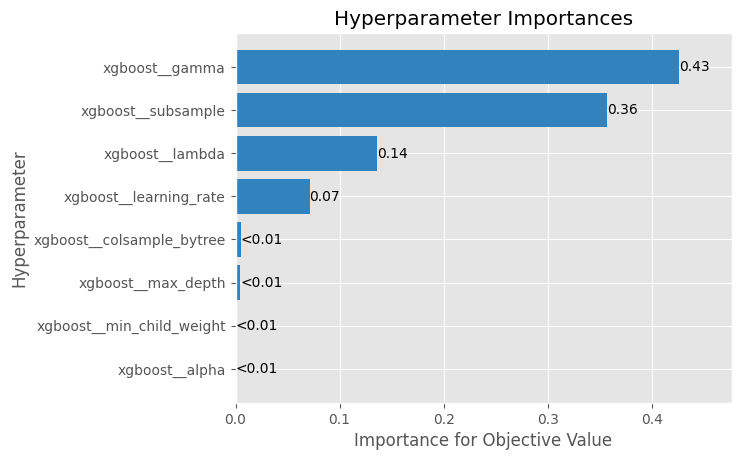

In [ ]:
plot_param_importances(xgboost_mae_tuned.study_)

In [ ]:
print(xgboost_mae_tuned.best_estimator_[1].get_params()['learning_rate'])
print(xgboost_mae_tuned.best_estimator_[1].get_params()['subsample'])
print(xgboost_mae_tuned.best_estimator_[1].get_params()['colsample_bytree'])

0.07569025229608825
0.8850602636765063
0.39966216155890855


Veamos los valores concretos y cómo afecta a la métrica objetivo (MAE)

[W 2023-04-13 16:31:31,199] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
[W 2023-04-13 16:31:31,319] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
[W 2023-04-13 16:31:31,436] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<Axes: title={'center': 'Contour Plot'}, xlabel='xgboost__colsample_bytree', ylabel='xgboost__subsample'>

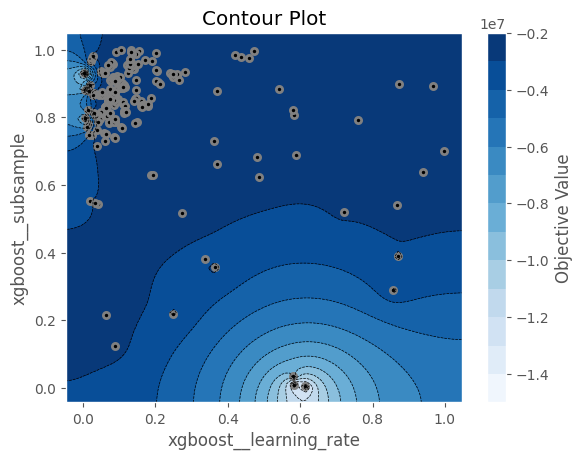

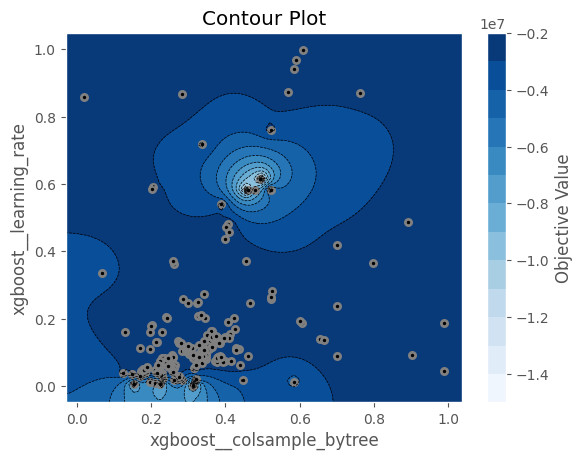

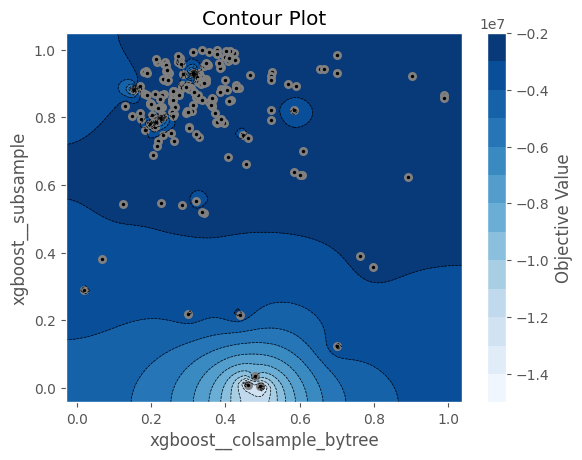

In [ ]:
plot_contour(xgboost_mae_tuned.study_, params=['xgboost__learning_rate', 'xgboost__subsample'])
plot_contour(xgboost_mae_tuned.study_, params=['xgboost__learning_rate', 'xgboost__colsample_bytree'])
plot_contour(xgboost_mae_tuned.study_, params=['xgboost__subsample', 'xgboost__colsample_bytree'])

In [ ]:
np.random.seed(random_seed)
random.seed(random_seed)
pipe_xgboost = Pipeline([
    ('scaler', StandardScaler()),
    ('xgboost', XGBRegressor(eval_metric='rmse', seed=random_seed))
    ])

start = time.time()
xgboost_rmse_tuned = evaluate(pipe_xgboost, X_train, y_train, cv=ps, fit_params=fit_params, tune=True, metric="neg_root_mean_squared_error", jobs=-1)
xgboost_rmse_tuned_time = time.time() - start

xgboost_rmse_tuned.best_estimator_

[I 2023-04-12 21:05:57,381] A new study created in memory with name: no-name-a5b074d9-ad5d-4f6f-aed1-2f03b4a45af7
[I 2023-04-12 21:05:59,366] Trial 0 finished with value: -7088797.023280151 and parameters: {'xgboost__learning_rate': 0.9965020810793019, 'xgboost__gamma': 6949.250444421467, 'xgboost__max_depth': 4, 'xgboost__min_child_weight': 7, 'xgboost__subsample': 0.45361403340010986, 'xgboost__lambda': 0.7145088781464429, 'xgboost__alpha': 7.90608096955974, 'xgboost__colsample_bytree': 0.13119686498785144}. Best is trial 0 with value: -7088797.023280151.
[I 2023-04-12 21:05:59,489] Trial 1 finished with value: -6877536.999532139 and parameters: {'xgboost__learning_rate': 0.08442204279802634, 'xgboost__gamma': 0.6544570656906329, 'xgboost__max_depth': 4, 'xgboost__min_child_weight': 2, 'xgboost__subsample': 0.5864745284675524, 'xgboost__lambda': 6626.079711298426, 'xgboost__alpha': 168.5464240551805, 'xgboost__colsample_bytree': 0.6497347253739074}. Best is trial 1 with value: -68775

Pipeline(steps=[('scaler', StandardScaler()),
                ('xgboost',
                 XGBRegressor(alpha=4493.969688027658, base_score=None,
                              booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=0.8448179669388326,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric='rmse',
                              feature_types=None, gamma=15.331160929365566,
                              gpu_id=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None,
                              lambda=2780.8626315367796,
                              learning_rate=0.9060600944368213, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=6, max_leaves=None,
                              min_child_weight=3, missing=nan,
                              monotone_constraints=None, n_estimators=100,
                              n_jobs=None, num_parallel_tree=None, ...))])

<Axes: title={'center': 'Hyperparameter Importances'}, xlabel='Importance for Objective Value', ylabel='Hyperparameter'>

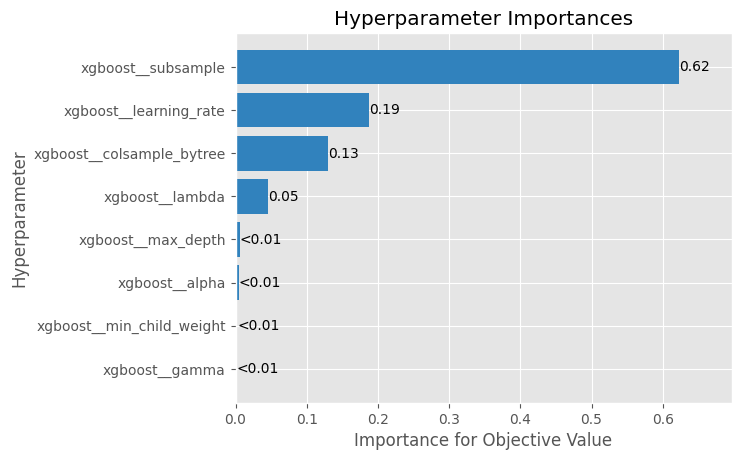

In [ ]:
plot_param_importances(xgboost_rmse_tuned.study_)

[W 2023-04-12 21:25:02,981] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
[W 2023-04-12 21:25:03,062] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.
[W 2023-04-12 21:25:03,129] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


<Axes: title={'center': 'Contour Plot'}, xlabel='xgboost__colsample_bytree', ylabel='xgboost__subsample'>

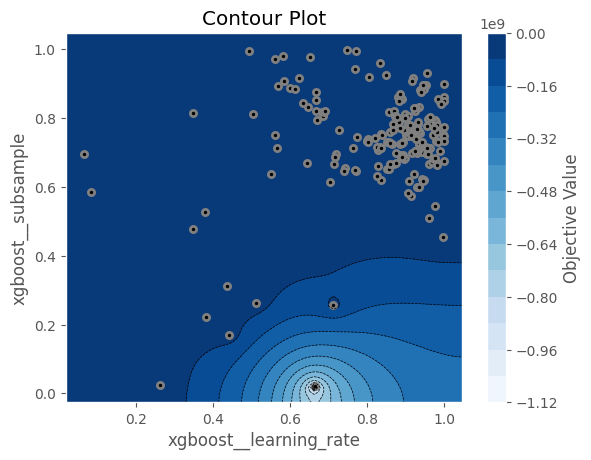

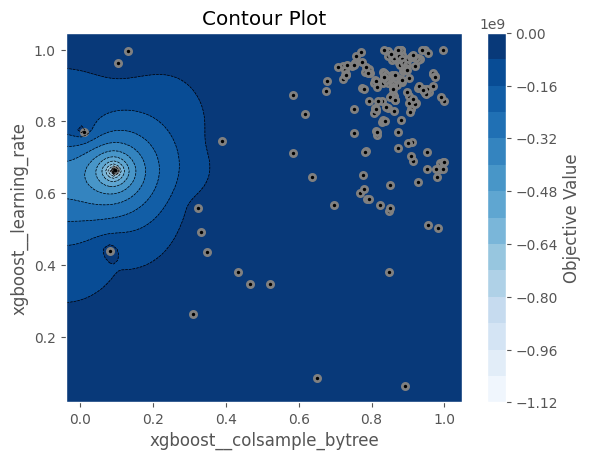

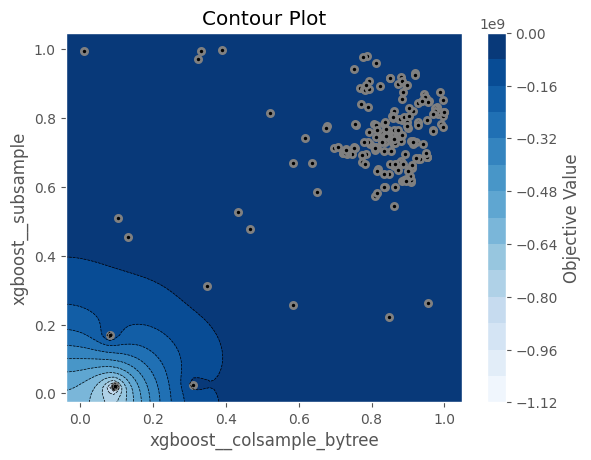

In [ ]:
plot_contour(xgboost_rmse_tuned.study_, params=['xgboost__learning_rate', 'xgboost__subsample'])
plot_contour(xgboost_rmse_tuned.study_, params=['xgboost__learning_rate', 'xgboost__colsample_bytree'])
plot_contour(xgboost_rmse_tuned.study_, params=['xgboost__subsample', 'xgboost__colsample_bytree'])

In [ ]:
print("MAE de XGBoost con hiperparámetros ajustados en validación: ", -xgboost_mae_tuned.best_score_)
print("RMSE de XGBoost con hiperparámetros ajustados en validación: ", -xgboost_rmse_tuned.best_score_)

MAE de XGBoost con hiperparámetros ajustados en validación:  2064001.5851027397
RMSE de XGBoost con hiperparámetros ajustados en validación:  3074925.782936388


## Comparación de modelos avanzados

Comparación de error de validación

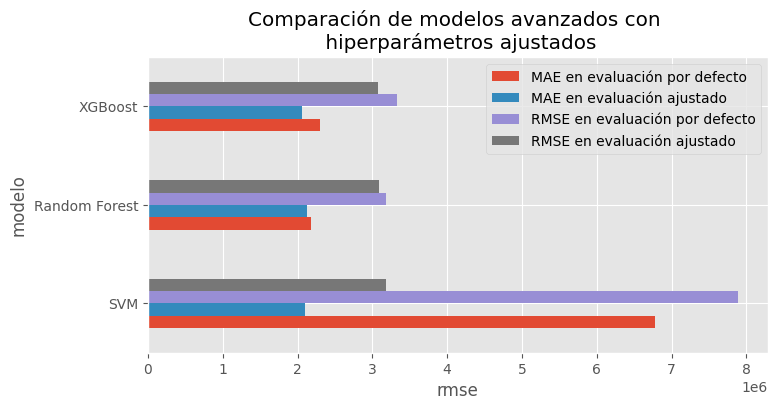

,modelo,MAE en evaluación por defecto,MAE en evaluación ajustado,RMSE en evaluación por defecto,RMSE en evaluación ajustado
0,SVM,6.784908e+06,2.100506e+06,7.893665e+06,3.183252e+06
1,Random Forest,2.184057e+06,2.132282e+06,3.179438e+06,3.087965e+06
2,XGBoost,2.297954e+06,2.064002e+06,3.326451e+06,3.074926e+06


In [ ]:
mae_svr_default = -svr_default["test_neg_mean_absolute_error"][0]
mae_rf_default = -rf_default["test_neg_mean_absolute_error"][0]
mae_xgboost_default = -xgboost_default["test_neg_mean_absolute_error"][0]
rmse_svr_default = -svr_default["test_neg_root_mean_squared_error"][0]
rmse_rf_default = -rf_default["test_neg_root_mean_squared_error"][0]
rmse_xgboost_default = -xgboost_default["test_neg_root_mean_squared_error"][0]

mae_svr_tuned = -svr_mae_tuned.best_score_
mae_rf_tuned = -rf_mae_tuned.best_score_
mae_xgboost_tuned = -xgboost_mae_tuned.best_score_
rmse_svr_tuned = -svr_rmse_tuned.best_score_
rmse_rf_tuned = -rf_rmse_tuned.best_score_
rmse_xgboost_tuned = -xgboost_rmse_tuned.best_score_

df_comparacion = pd.DataFrame({
                    'modelo': ['SVM', 'Random Forest', 'XGBoost'],
                    'MAE en evaluación por defecto': [mae_svr_default, mae_rf_default, mae_xgboost_default],
                    'MAE en evaluación ajustado': [mae_svr_tuned, mae_rf_tuned, mae_xgboost_tuned],
                    'RMSE en evaluación por defecto': [rmse_svr_default, rmse_rf_default, rmse_xgboost_default],
                    'RMSE en evaluación ajustado': [rmse_svr_tuned, rmse_rf_tuned, rmse_xgboost_tuned]
                 })

fig, ax = plt.subplots(figsize=(8, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('error')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos avanzados con \n hiperparámetros ajustados')
plt.show()

df_comparacion

Los tiempos de ajuste han sido los siguientes

In [ ]:
df_comparacion = pd.DataFrame({
                    'modelo': ['SVR', 'Random Forest', 'XGBoost'],
                    'MAE ': [svr_mae_tuned_time, rf_mae_tuned_time, xgboost_mae_tuned_time,],
                    'RMSE': [svr_rmse_tuned_time, rf_rmse_tuned_time, xgboost_rmse_tuned_time]
                 })

fig, ax = plt.subplots(figsize=(8, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de tiempos de ajuste de modelos avanzados con \n hiperparámetros ajustados')
plt.show()

df_comparacion

## Importancia de cada atributo

Random Forest

In [ ]:
importances = rf_mae_tuned.best_estimator_.feature_importances_
indices = np.argsort(importances)

plt.title('Importancia de los atributos')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X_df.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

XGBoost

In [ ]:
plot_importance(xgboost_mae_tuned.best_estimator_, max_num_features=20) # top 10 most important features
plt.show()

Conclusiones hasta el momento:

De momento consideramos a SVM como el peor modelo en términos de entrenamiento

XGBoost parece el más prometedor

# Selección del mejor modelo

Dados los errores de validación y nuestro conocimiento hemos decidido usar XGBoost entrenado sobre la métrica MAE con los hiperparámetros obtenidos durante la validación cruzada

Evaluación con test

In [ ]:
print("MAE de test de XGBoost con hiperparámetros ajustados", MAE(y_test, xgboost_mae_tuned.best_estimator_.predict(X_test)))
print("RMSE de test de XGBoost con hiperparámetros ajustados", RMSE(y_test, xgboost_mae_tuned.best_estimator_.predict(X_test)))
print("R2 de test de XGBoost con hiperparámetros ajustados", metrics.r2_score(y_test, xgboost_mae_tuned.best_estimator_.predict(X_test)))

MAE de test de XGBoost con hiperparámetros ajustados 2088943.8825342467
RMSE de test de XGBoost con hiperparámetros ajustados 3194580.858910737
R2 de test de XGBoost con hiperparámetros ajustados 0.822554600516746
